<a href="https://colab.research.google.com/github/KEVORK890/research/blob/master/BTC_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed



📈 Trend Strategy (30d) Metrics:
  CAGR:        22.57%
  Volatility:  17.17%
  Sharpe:      1.31
  Sortino:     1.44
  Max Drawdown:-28.51%
  MAR Ratio:   0.79

📈 BTC Buy & Hold Metrics:
  CAGR:        41.42%
  Volatility:  53.38%
  Sharpe:      0.78
  Sortino:     1.06
  Max Drawdown:-76.63%
  MAR Ratio:   0.54


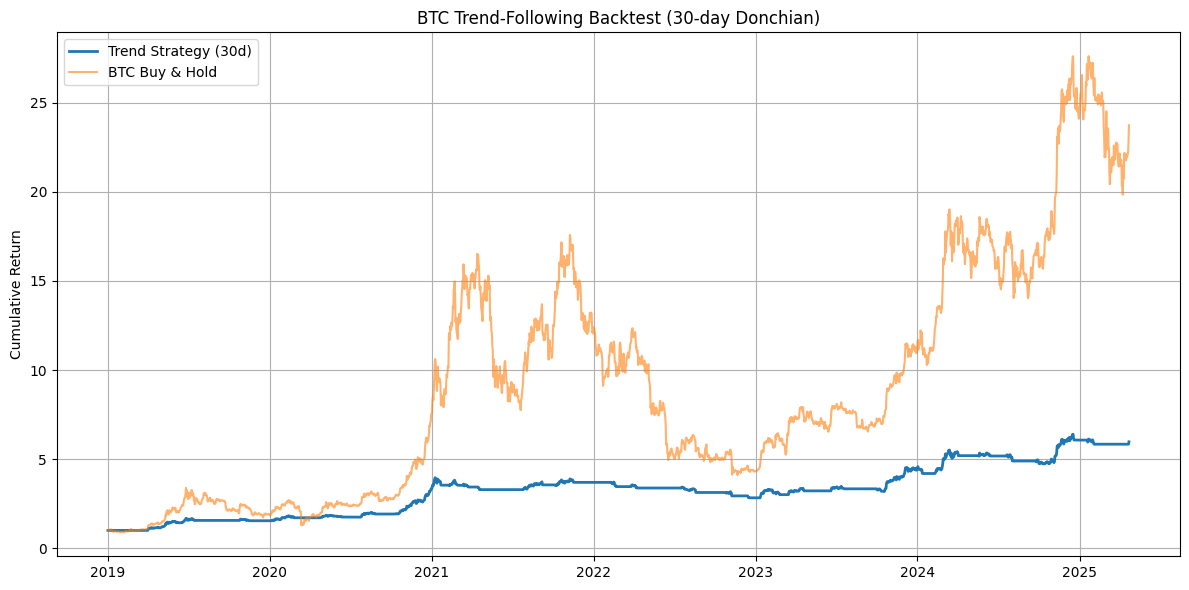

In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
lookback = 30                # Donchian lookback period days (customize here)
target_vol = 0.25               # Target annualized volatility
max_leverage = 2             # Cap on position size
transaction_cost = 0.001     # 10bps
start_date = "2019-01-01"    # Start of backtest

# --- Download and Prepare Data ---
btc = yf.download("BTC-USD", start=start_date)

# Flatten multi-index columns if needed
if isinstance(btc.columns, pd.MultiIndex):
    btc.columns = btc.columns.get_level_values(0)

btc = btc[['Close']].dropna()
btc['Return'] = btc['Close'].pct_change()

# --- Donchian Strategy Function ---
def run_donchian_strategy(df, n):
    df_ = df.copy()
    df_['Donchian_Up'] = df_['Close'].rolling(n).max()
    df_['Donchian_Down'] = df_['Close'].rolling(n).min()
    df_['Donchian_Mid'] = (df_['Donchian_Up'] + df_['Donchian_Down']) / 2

    signal = []
    trailing_stop = np.nan
    in_position = False

    for i in range(len(df_)):
        close = df_['Close'].iloc[i]
        upper = df_['Donchian_Up'].iloc[i]
        mid = df_['Donchian_Mid'].iloc[i]

        if np.isnan(upper) or np.isnan(mid):
            signal.append(0)
            continue

        if not in_position and close >= upper:
            in_position = True
            trailing_stop = mid
            signal.append(1)
        elif in_position:
            trailing_stop = max(trailing_stop, mid)
            if close < trailing_stop:
                in_position = False
                trailing_stop = np.nan
                signal.append(0)
            else:
                signal.append(1)
        else:
            signal.append(0)

    df_['Signal'] = signal
    df_['Vol'] = df_['Return'].rolling(90).std() * np.sqrt(252)
    df_['Weight'] = (target_vol / df_['Vol']).clip(upper=max_leverage)
    df_['Position'] = df_['Signal'].shift(1) * df_['Weight']
    df_['Strategy_Return'] = df_['Position'] * df_['Return']
    df_['Cost_Adjusted'] = df_['Strategy_Return'] - transaction_cost * df_['Position'].diff().abs()

    return df_

# --- Performance Metrics Function ---
def compute_metrics(df, return_col, label):
    r = df[return_col].dropna()
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak

    cagr = (cum.iloc[-1])**(252 / len(r)) - 1
    vol = r.std() * np.sqrt(252)
    sharpe = cagr / vol if vol > 0 else np.nan
    sortino = cagr / (r[r < 0].std() * np.sqrt(252)) if (r < 0).any() else np.nan
    max_dd = drawdown.min()
    mar = cagr / abs(max_dd) if max_dd < 0 else np.nan

    print(f"\n📈 {label} Metrics:")
    print(f"  CAGR:        {cagr:.2%}")
    print(f"  Volatility:  {vol:.2%}")
    print(f"  Sharpe:      {sharpe:.2f}")
    print(f"  Sortino:     {sortino:.2f}")
    print(f"  Max Drawdown:{max_dd:.2%}")
    print(f"  MAR Ratio:   {mar:.2f}")

# --- Run Backtest ---
result = run_donchian_strategy(btc, lookback)

# --- Compute Metrics ---
compute_metrics(result, 'Cost_Adjusted', f'Trend Strategy ({lookback}d)')
compute_metrics(result, 'Return', 'BTC Buy & Hold')

# --- Plot Cumulative Returns ---
result['Cum_Strategy'] = (1 + result['Cost_Adjusted'].fillna(0)).cumprod()
result['Cum_BTC'] = (1 + result['Return'].fillna(0)).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(result['Cum_Strategy'], label=f'Trend Strategy ({lookback}d)', linewidth=2)
plt.plot(result['Cum_BTC'], label='BTC Buy & Hold', alpha=0.6)
plt.title(f"BTC Trend-Following Backtest ({lookback}-day Donchian)")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()





In [56]:
result

Price,Close,Return,Donchian_Up,Donchian_Down,Donchian_Mid,Signal,Vol,Weight,Position,Strategy_Return,Cost_Adjusted,Cum_Strategy,Cum_BTC
Date,,,,,,,,,,,,,
2019-01-01,3843.520020,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
2019-01-02,3943.409424,0.025989,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1.000000,1.025989
2019-01-03,3836.741211,-0.027050,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1.000000,0.998236
2019-01-04,3857.717529,0.005467,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1.000000,1.003694
2019-01-05,3845.194580,-0.003246,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1.000000,1.000436
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-18,84450.804688,-0.005241,87498.914062,76271.953125,81885.433594,0,0.456474,0.547676,0.000000,-0.000000,-0.000000,5.838411,21.972256
2025-04-19,85063.414062,0.007254,87498.914062,76271.953125,81885.433594,0,0.453916,0.550763,0.000000,0.000000,0.000000,5.838411,22.131643
2025-04-20,85174.304688,0.001304,87498.914062,76271.953125,81885.433594,0,0.453582,0.551168,0.000000,0.000000,0.000000,5.838411,22.160495


<Axes: xlabel='Date'>

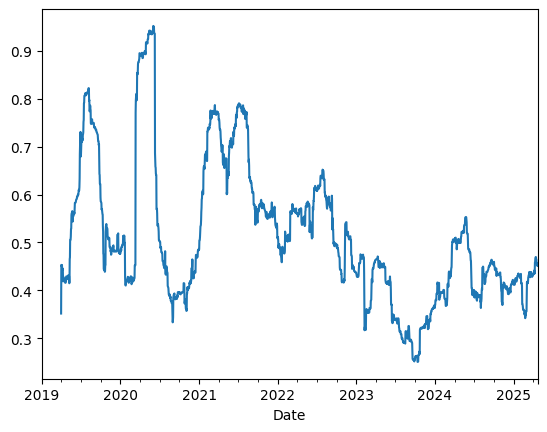

In [34]:
result.Vol.plot()

[*********************100%***********************]  1 of 1 completed



📈 Donchian Combo Strategy Performance:
  CAGR:        28.93%
  Volatility:  28.39%
  Sharpe:      1.02
  Sortino:     1.34
  Max Drawdown:-47.78%
  MAR Ratio:   0.61

📊 Position Stats:
  Avg Weight:    1.00
  Annual Turnover: 11.03
  % Days Invested: 85.28%


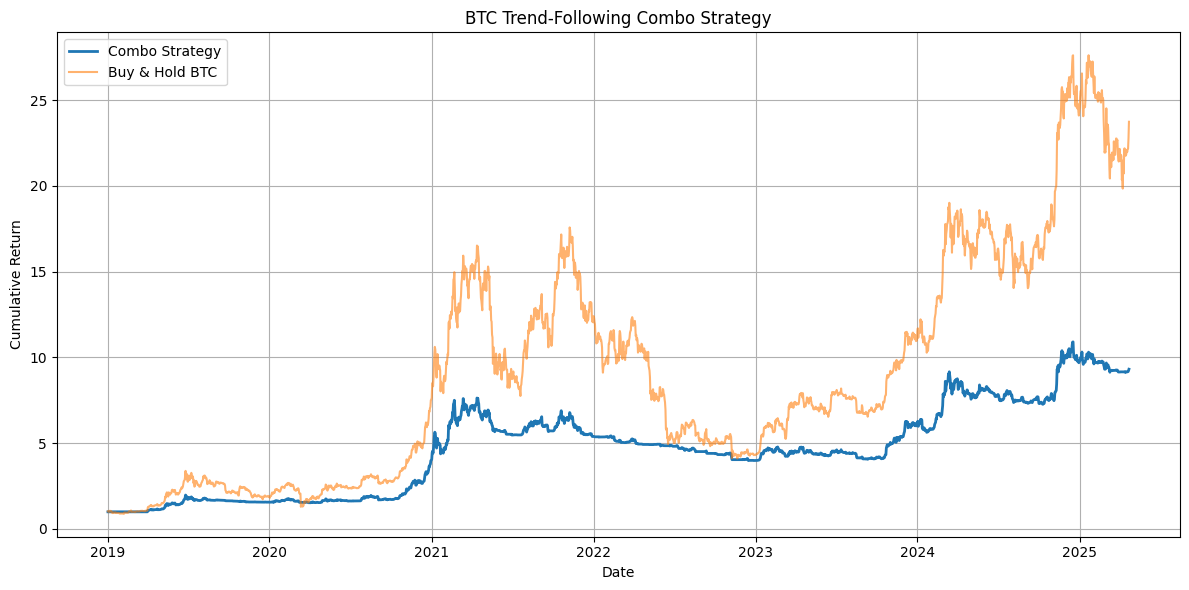

In [57]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------- SETTINGS -------------------
lookbacks = [5, 10, 20, 30, 60, 90, 150, 250, 360]
target_volatility = 1     # annualized vol target
max_leverage = 1           # position cap
transaction_cost = 0.00001     # 10bps
start_date = "2019-01-01"
symbol = "BTC-USD"

# ------------------- LOAD DATA -------------------
btc = yf.download(symbol, start=start_date)

if isinstance(btc.columns, pd.MultiIndex):
    btc.columns = btc.columns.get_level_values(0)

btc = btc[['Close']].dropna()
btc['Return'] = btc['Close'].pct_change()
btc.dropna(inplace=True)

# ------------------- STRATEGY FUNCTION -------------------
def run_donchian_strategy(df, n, vol_target, max_leverage):
    df_ = df.copy()
    df_['Donchian_Up'] = df_['Close'].rolling(n).max()
    df_['Donchian_Down'] = df_['Close'].rolling(n).min()
    df_['Donchian_Mid'] = (df_['Donchian_Up'] + df_['Donchian_Down']) / 2

    signal = []
    trailing_stop = np.nan
    in_position = False

    for i in range(len(df_)):
        close = df_['Close'].iloc[i]
        upper = df_['Donchian_Up'].iloc[i]
        mid = df_['Donchian_Mid'].iloc[i]

        if np.isnan(upper) or np.isnan(mid):
            signal.append(0)
            continue

        if not in_position and close >= upper:
            in_position = True
            trailing_stop = mid
            signal.append(1)
        elif in_position:
            trailing_stop = max(trailing_stop, mid)
            if close < trailing_stop:
                in_position = False
                trailing_stop = np.nan
                signal.append(0)
            else:
                signal.append(1)
        else:
            signal.append(0)

    df_['Signal'] = signal
    df_['Vol'] = df_['Return'].rolling(90).std() * np.sqrt(252)
    df_['Weight'] = (vol_target / df_['Vol']).clip(upper=max_leverage)
    df_['Position'] = df_['Signal'].shift(1) * df_['Weight']
    return df_[['Position', 'Weight']]

# ------------------- RUN COMBO -------------------
position_df = pd.DataFrame(index=btc.index)
weight_df = pd.DataFrame(index=btc.index)

for n in lookbacks:
    result = run_donchian_strategy(btc, n, target_volatility, max_leverage)
    position_df[f'Position_{n}'] = result['Position']
    weight_df[f'Weight_{n}'] = result['Weight']

# Ensemble average
btc['Combo_Position'] = position_df.mean(axis=1)
btc['Combo_Weight'] = weight_df.mean(axis=1)

# Returns and PnL
btc['Strategy_Return'] = btc['Combo_Position'].shift(1) * btc['Return']
btc['Cost_Adjusted'] = btc['Strategy_Return'] - transaction_cost * btc['Combo_Position'].diff().abs()
btc['Cumulative_Return'] = (1 + btc['Cost_Adjusted'].fillna(0)).cumprod()
btc['BuyHold_Cum'] = (1 + btc['Return'].fillna(0)).cumprod()

# ------------------- PERFORMANCE METRICS -------------------
def compute_metrics(series, strategy_name):
    r = series.dropna()
    daily_ret = r
    ann_ret = (1 + r).prod()**(252/len(r)) - 1
    ann_vol = r.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    sortino = ann_ret / (r[r < 0].std() * np.sqrt(252)) if (r < 0).any() else np.nan
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak
    max_dd = drawdown.min()
    mar = ann_ret / abs(max_dd) if max_dd != 0 else np.nan

    print(f"\n📈 {strategy_name} Performance:")
    print(f"  CAGR:        {ann_ret:.2%}")
    print(f"  Volatility:  {ann_vol:.2%}")
    print(f"  Sharpe:      {sharpe:.2f}")
    print(f"  Sortino:     {sortino:.2f}")
    print(f"  Max Drawdown:{max_dd:.2%}")
    print(f"  MAR Ratio:   {mar:.2f}")
    return

compute_metrics(btc['Cost_Adjusted'], "Donchian Combo Strategy")

# Position stats
avg_weight = btc['Combo_Weight'].mean()
turnover = btc['Combo_Position'].diff().abs().mean() * 252
invested_pct = (btc['Combo_Position'] != 0).mean()

print("\n📊 Position Stats:")
print(f"  Avg Weight:    {avg_weight:.2f}")
print(f"  Annual Turnover: {turnover:.2f}")
print(f"  % Days Invested: {invested_pct:.2%}")

# ------------------- PLOT -------------------
plt.figure(figsize=(12, 6))
plt.plot(btc['Cumulative_Return'], label='Combo Strategy', linewidth=2)
plt.plot(btc['BuyHold_Cum'], label='Buy & Hold BTC', alpha=0.6)
plt.title('BTC Trend-Following Combo Strategy')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
btc

Price,Close,Return,Combo_Position,Combo_Weight,Strategy_Return,Cost_Adjusted,Cumulative_Return,BuyHold_Cum
Date,,,,,,,,
2019-01-02,3943.409424,0.025989,NaN,NaN,NaN,NaN,1.000000,1.025989
2019-01-03,3836.741211,-0.027050,NaN,NaN,NaN,NaN,1.000000,0.998236
2019-01-04,3857.717529,0.005467,NaN,NaN,NaN,NaN,1.000000,1.003694
2019-01-05,3845.194580,-0.003246,NaN,NaN,NaN,NaN,1.000000,1.000436
2019-01-06,4076.632568,0.060189,NaN,NaN,NaN,NaN,1.000000,1.060651
...,...,...,...,...,...,...,...,...
2025-04-18,84450.804688,-0.005241,0.222222,1.0,-0.000582,-0.000583,9.153670,21.972256
2025-04-19,85063.414062,0.007254,0.222222,1.0,0.001612,0.001612,9.168426,22.131643
2025-04-20,85174.304688,0.001304,0.222222,1.0,0.000290,0.000290,9.171082,22.160495
